In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import csv
import os
import re
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pykrx import stock
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, silhouette_score
import FinanceDataReader as fdr
import yfinance as yf
import seaborn as sns
import warnings
warnings.filterwarnings(action = "ignore")

pd.set_option('display.max_rows', None)

# 데이터 로드

## 회사 심볼 및 회사명

In [2]:
stock_list = []
BaseUrl = 'http://finance.naver.com/sise/entryJongmok.nhn?&page='

for i in range(1, 21):
    url = BaseUrl + str(i)
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')
    items = soup.find_all('td', {'class': 'ctg'})

    for item in items:
        # print(item)
        txt = item.a.get('href') 
        k = re.search('[\d]+', txt) ##정규표현식 사용. [\d] 숫자표현, + : 반복
        
        if k:
            code = k.group()
            name = item.text
            data = code, name
            stock_list.append(data)
            

# 코스피 상위 200 종목 이름 가져오기
stock_name = []            
for i in range(len(stock_list)):
    stock_name.append(stock_list[i][1])
    
stock_code = []
for i in range(len(stock_list)):
    stock_code.append(stock_list[i][0])

In [3]:
a = pd.DataFrame(stock_code)
b = pd.DataFrame(stock_name)
df_krx = pd.concat([a,b], axis=1)
df_krx.columns = ["Symbol","Name"]
df_krx.head()

,Symbol,Name
0,005930,삼성전자
1,373220,LG에너지솔루션
2,000660,SK하이닉스
3,207940,삼성바이오로직스
4,051910,LG화학


## 업종

In [4]:
krx = fdr.StockListing("KRX")
df_kospi_200 = pd.merge(left=df_krx, right=krx, how="left", on="Symbol")
df_kospi_200 = df_kospi_200[["Symbol","Name_x","Sector"]]
df_kospi_200.columns = ["Symbol", "Name", "Sector"]
df_kospi_200.head()

,Symbol,Name,Sector
0,005930,삼성전자,통신 및 방송 장비 제조업
1,373220,LG에너지솔루션,일차전지 및 축전지 제조업
2,000660,SK하이닉스,반도체 제조업
3,207940,삼성바이오로직스,기초 의약물질 및 생물학적 제제 제조업
4,051910,LG화학,기초 화학물질 제조업


In [5]:
df_kospi_200.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Symbol  200 non-null    object
 1   Name    200 non-null    object
 2   Sector  200 non-null    object
dtypes: object(3)
memory usage: 6.2+ KB


## 2022년 주가 데이터

In [6]:
close_list = []
start_date = '2022-01-01'
end_date = '2022-12-31'
for i in (df_kospi_200["Symbol"]):
    print(i)
    try:
        close = yf.download(f'{i}.KS', start_date, end_date)["Adj Close"]
        close = pd.DataFrame(close)
        close.columns = [i]
        close_list.append(close)
    except:
        pass

df_close = pd.concat(close_list, axis=1)
df_close.sort_index(inplace=True)

df_close.head()

005930
[*********************100%***********************]  1 of 1 completed
373220
[*********************100%***********************]  1 of 1 completed
000660
[*********************100%***********************]  1 of 1 completed
207940
[*********************100%***********************]  1 of 1 completed
051910
[*********************100%***********************]  1 of 1 completed
006400
[*********************100%***********************]  1 of 1 completed
005380
[*********************100%***********************]  1 of 1 completed
035420
[*********************100%***********************]  1 of 1 completed
035720
[*********************100%***********************]  1 of 1 completed
000270
[*********************100%***********************]  1 of 1 completed
005490
[*********************100%***********************]  1 of 1 completed
105560
[*********************100%***********************]  1 of 1 completed
068270
[*********************100%***********************]  1 of 1 completed
028260
[****

,005930,373220,000660,207940,051910,006400,005380,035420,035720,000270,...,294870,005440,020000,003850,284740,057050,105630,004490,381970,241590
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-04,77288.390625,NaN,127303.171875,888000.0,644000.0,649000.0,208870.96875,363833.81250,112319.937500,83500.0,...,24650.0,8470.0,36300.0,14700.0,38900.0,62700.0,21387.837891,75100.0,31601.044922,17250.0
2022-01-05,76011.718750,NaN,124331.109375,861000.0,664000.0,648000.0,212352.15625,353381.68750,106275.812500,85900.0,...,24550.0,8440.0,36100.0,14400.0,39450.0,62600.0,21484.835938,73000.0,29850.833984,16550.0
2022-01-06,75520.687500,NaN,123835.765625,838000.0,690000.0,642000.0,212849.46875,336956.90625,100735.367188,85600.0,...,24850.0,8400.0,36400.0,14050.0,39100.0,63500.0,22648.798828,71300.0,28829.876953,16500.0
2022-01-07,76895.570312,NaN,125817.140625,844000.0,719000.0,636000.0,213844.09375,336459.18750,100735.367188,86700.0,...,25000.0,8420.0,36200.0,14150.0,39450.0,63500.0,22551.802734,71400.0,28149.238281,16550.0
2022-01-10,76600.960938,NaN,123340.421875,836000.0,710000.0,624000.0,208373.65625,333472.87500,97310.367188,83800.0,...,25800.0,8460.0,36600.0,13950.0,39400.0,63400.0,22648.798828,69900.0,27565.833984,16950.0


In [7]:
ret = df_close.pct_change().dropna().mean() * 252         #----- 수익률
std = df_close.pct_change().dropna().std() * np.sqrt(252) #----- 변동성
# acov = df_close.pct_change().dropna().cov() * 252 
mkrs = ret.index.tolist()

Text(0.5, 1.0, 'return(year) vs. std(year)')

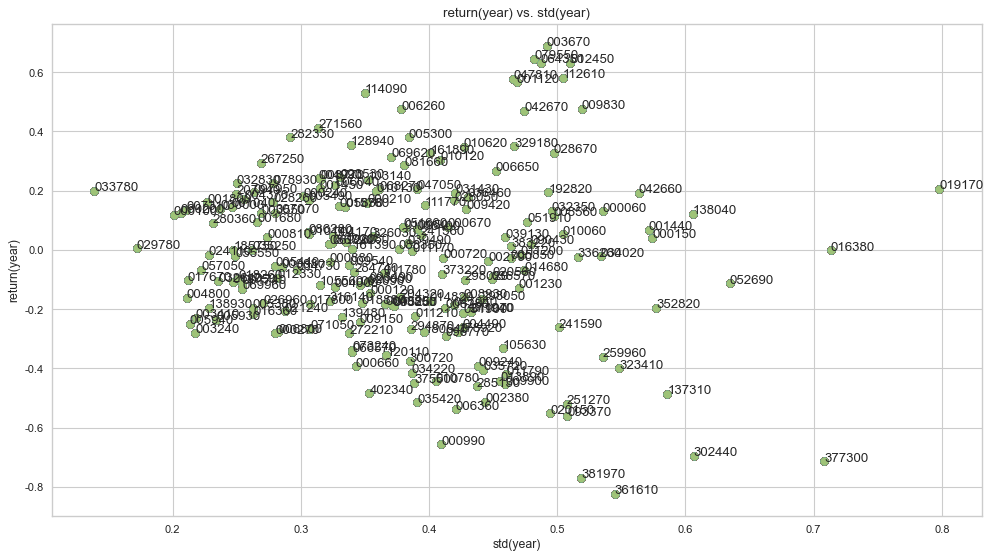

In [8]:
plt.figure(figsize=(15, 8), dpi=80)
for i in range(len(ret)):
    plt.scatter(std, ret)
    plt.annotate(mkrs[i], (std[i], ret[i]))
plt.xlabel('std(year)')
plt.ylabel('return(year)') 
plt.title("return(year) vs. std(year)")  

In [40]:
kospi200 = pd.DataFrame({"return(y)":ret, "std(y)":std})
kospi200 = kospi200.dropna(how="any")
kospi200.index.rename("Ticker", inplace=True)
kospi200.head() 

,return(y),std(y)
Ticker,,
005930,-0.235864,0.234096
373220,-0.080740,0.410411
000660,-0.392446,0.343029
207940,0.189859,0.249796
051910,0.094353,0.476635


## 2022년 평균 거래량

In [ ]:
# volume_list = []
# start_date = '2022-01-01'
# end_date = '2022-12-31'
# for i in (df_kospi_200["Symbol"]):
#     print(i)
#     try:
#         volume = yf.download(f'{i}.KS', start_date, end_date)["Volume"]
#         volume = pd.DataFrame(volume)
#         volume.columns = [i]
#         volume_list.append(volume)
#     except:
#         pass

# df_volume = pd.concat(volume_list, axis=1)
# df_volume.sort_index(inplace=True)

# df_volume.head()

## 2022년 가격변동 데이터

In [ ]:
change = stock.get_market_price_change_by_ticker(fromdate="20220101", todate="20221231",market='KOSPI')

In [ ]:
change.reset_index(inplace=True)
change_list = []
for i in kospi200.index:
    try:
        ch = change[change["티커"] == i].values
        ch = pd.DataFrame(ch)
        change_list.append(ch)
    except:
        pass
    
change_df = pd.concat(change_list,axis=0)
change_df.columns = change.columns
change_df.set_index("티커", inplace=True)
change_df.index.rename("Ticker", inplace=True)
change_df.head()
    

,종목명,시가,종가,변동폭,등락률,거래량,거래대금
Ticker,,,,,,,
005930,삼성전자,78300,55300,-23000,-29.37,3563190551,227074541164155
000660,SK하이닉스,131000,75000,-56000,-42.75,814456250,85071368297011
207940,삼성바이오로직스,903000,821000,-82000,-9.08,13792523,11361565334420
051910,LG화학,615000,600000,-15000,-2.44,68431145,40692524557406
006400,삼성SDI,655000,591000,-64000,-9.77,69013451,41451040626202


## 2022년 재무데이터

In [ ]:
fundamental = stock.get_market_fundamental_by_ticker(date='20220617', market="KOSPI")

In [ ]:
fundamental.reset_index(inplace=True)
fundamental_list = []
for i in kospi200.index:
    try:
        fd = fundamental[fundamental["티커"] == i].values
        fd = pd.DataFrame(fd)
        fundamental_list.append(fd)
    except:
        pass
    
fundamental_df = pd.concat(fundamental_list, axis=0)
fundamental_df.columns = fundamental.columns
fundamental_df.set_index("티커", inplace=True)
fundamental_df.index.rename("Ticker", inplace=True)
fundamental_df.head()

,BPS,PER,PBR,EPS,DIV,DPS
Ticker,,,,,,
005930,43611,10.35,1.37,5777,2.41,1444
373220,39831,107.37,10.68,3963,0.0,0
000660,90394,6.89,1.07,13989,1.6,1540
207940,74551,141.52,11.16,5879,0.0,0
051910,278455,12.27,2.08,47108,2.08,12000


## 활용할 데이터 병합

In [ ]:
# kospi200["등락률"] = change_df["등락률"]
# kospi200["변동폭"] = change_df["변동폭"]
# kospi200.dropna(axis=0, inplace=True)

## 데이터 Ticker 및 값 저장

In [ ]:
companies = list(kospi200.index)    #----- Ticker
companies
movements = kospi200.values         #----- Values
movements

array([[-2.35864278e-01,  2.34096342e-01],
       [-8.07403144e-02,  4.10411297e-01],
       [-3.92445864e-01,  3.43029402e-01],
       [ 1.89859010e-01,  2.49795557e-01],
       [ 9.43533087e-02,  4.76635347e-01],
       [ 7.04752594e-02,  3.90355666e-01],
       [-1.94836601e-01,  2.62610312e-01],
       [-5.14695923e-01,  3.90819345e-01],
       [-4.04904657e-01,  4.42267888e-01],
       [-2.81750880e-01,  2.80049751e-01],
       [ 1.69201403e-01,  3.06283762e-01],
       [-1.16981609e-01,  3.14622140e-01],
       [ 2.05381098e-01,  3.61054706e-01],
       [ 1.63246269e-01,  2.78712823e-01],
       [-2.18844634e-02,  2.48798846e-01],
       [-9.36180328e-02,  2.81837200e-01],
       [-3.43928000e-01,  3.39985699e-01],
       [ 2.08250510e-02,  3.22384398e-01],
       [ 2.24617620e-01,  2.50054134e-01],
       [-6.61545232e-02,  2.96663486e-01],
       [ 6.88692813e-01,  4.91729845e-01],
       [-2.89367960e-01,  4.13151886e-01],
       [ 1.45518240e-01,  3.34521122e-01],
       [-3.

# Clustering

## 데이터 정규화

In [ ]:
normalize = Normalizer()
norm_array = normalize.fit_transform(kospi200)
df_norm = pd.DataFrame(norm_array, columns = kospi200.columns)
final_df = df_norm.set_index(kospi200.index)
final_df.head(10)

,return(y),std(y)
Ticker,,
005930,-0.709762,0.704442
373220,-0.193030,0.981193
000660,-0.752920,0.658113
207940,0.605112,0.796140
051910,0.194189,0.980964
006400,0.177669,0.984090
005380,-0.595840,0.803103
035420,-0.796423,0.604740
035720,-0.675265,0.737576


## 클러스터 수 비교 및 지정

In [ ]:
# 클러스터 수 지정(2~12)
num_of_clusters = range(2,12)
# 에러 계산 빈 리스트 생성
error = []

# 가장 중요한 파라미터는 클러스터 개수.
# 클러스터링 후 fit() 함수를 이용해 데이터에 적합시킵니다.
for num_clusters in num_of_clusters:
    clusters = KMeans(num_clusters)
    clusters.fit(final_df)
    error.append(clusters.inertia_/100)    

# 계산된 값 데이터프레임으로 return
table=pd.DataFrame({"Cluster_Numbers":num_of_clusters, "Error_Term":error})

table

,Cluster_Numbers,Error_Term
0,2,0.148269
1,3,0.064238
2,4,0.037155
3,5,0.023496
4,6,0.016820
5,7,0.012270
6,8,0.008947
7,9,0.006706
8,10,0.005542
9,11,0.004350


<bound method BaseEstimator._validate_data of KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001D5EDBD7F10>,
                 estimator=KMeans(n_clusters=11), k=(2, 12))>

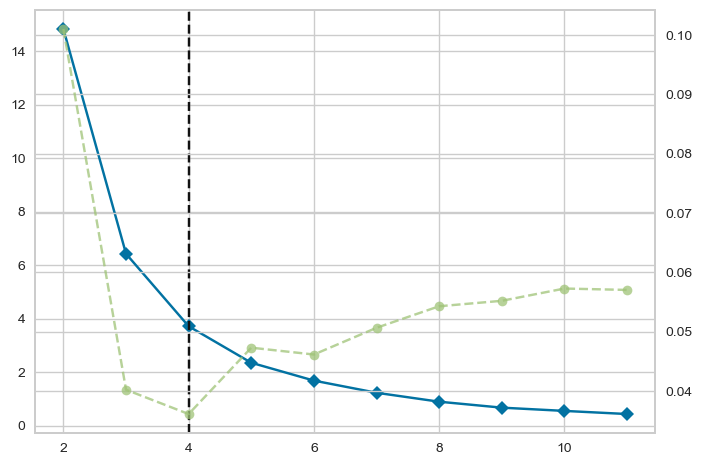

In [ ]:
# KMeans 알고리즘에서 최적의 클러스터를 선택하기 위해서는 엘보(elbow) 방법과 실루엣(silhouette) 방법을 사용
# 엘보(elbow) : 군집을 추가로 늘려가면서 군집내 변동성이 급감하는 개수를 찾는 방법
# 실루엣(silhouette) : 각 데이터별로 그 데이터가 속한 군 내의 유사도와 인접한 군의 유사도를 비교하는 지표(거리기반)

model = KMeans()
visualizer = KElbowVisualizer(model, k = (2,12))
visualizer.fit(final_df)._validate_data

In [ ]:
clusters = KMeans(4, random_state=1111)
clusters.fit(final_df)
clusters.labels_

labels = clusters.predict(movements)
print(labels)

cluster= pd.DataFrame({'labels' : labels, 'Symbol':companies})
cluster.head()

[0 2 0 1 3 3 0 0 0 0 1 2 1 1 3 2 0 3 1 2 1 0 1 0 1 1 2 0 1 3 2 2 3 3 3 2 1
 1 2 2 1 3 0 0 3 2 3 2 3 3 3 0 3 3 2 1 3 0 2 1 0 1 1 0 3 2 2 1 3 2 0 3 0 1
 0 3 3 1 1 3 0 1 3 0 1 1 1 0 1 1 0 3 0 1 1 0 1 1 1 1 1 0 0 0 3 1 3 1 1 3 2
 0 0 2 2 1 3 1 1 2 3 2 3 3 2 0 0 0 0 3 3 2 1 2 1 2 1 2 1 1 3 2 2 1 3 0 2 0
 2 0 1 1 1 2 1 0 2 0 2 2 3 1 2 2 0 3 1 3 3 0 3 1 3 2 1 1 0 3 3 1 3 0 0 3 3
 0 2 0 3 0 0 2 2 2 2 2 0 2 0 2]


,labels,Symbol
0,0,005930
1,2,373220
2,0,000660
3,1,207940
4,3,051910


In [ ]:
# 군집에 따른 회사명과 업종 데이터프레임 합쳐서 확인하기 
clustered_result = pd.merge(left=cluster, right=df_kospi_200, how="inner", on="Symbol")
clustered_result.sort_values("labels").head()

,labels,Symbol,Name,Sector
0,0,005930,삼성전자,통신 및 방송 장비 제조업
145,0,004800,효성,기타 금융업
42,0,377300,카카오페이,금융 지원 서비스업
43,0,259960,크래프톤,소프트웨어 개발 및 공급업
127,0,006360,GS건설,건물 건설업


In [ ]:
final_df['Cluster'] = clusters.labels_
final_df.head()

,return(y),std(y),Cluster
Ticker,,,
005930,-0.709762,0.704442,0
373220,-0.193030,0.981193,2
000660,-0.752920,0.658113,0
207940,0.605112,0.796140,1
051910,0.194189,0.980964,3


## 클러스터 결과 값 확인

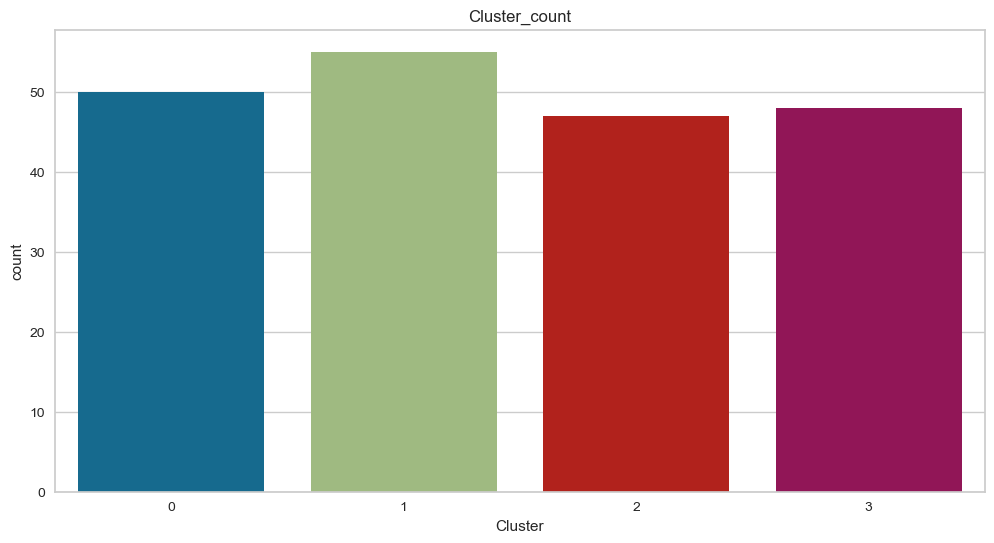

<Figure size 800x550 with 0 Axes>

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x = 'Cluster', data = final_df)
plt.title('Cluster_count')
plt.show()
plt.savefig('cluster_count.png', dpi=300)

In [ ]:
clustered_result.groupby('labels').get_group(0)

,labels,Symbol,Name,Sector
0,0,005930,삼성전자,통신 및 방송 장비 제조업
2,0,000660,SK하이닉스,반도체 제조업
6,0,005380,현대차,자동차용 엔진 및 자동차 제조업
7,0,035420,NAVER,"자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업"
8,0,035720,카카오,"자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업"
9,0,000270,기아,자동차용 엔진 및 자동차 제조업
16,0,066570,LG전자,통신 및 방송 장비 제조업
21,0,096770,SK이노베이션,석유 정제품 제조업
23,0,323410,카카오뱅크,은행 및 저축기관
27,0,009150,삼성전기,전자부품 제조업


In [ ]:
clustered_result.groupby('labels').get_group(1)

,labels,Symbol,Name,Sector
3,1,207940,삼성바이오로직스,기초 의약물질 및 생물학적 제제 제조업
10,1,005490,POSCO홀딩스,1차 철강 제조업
12,1,068270,셀트리온,기초 의약물질 및 생물학적 제제 제조업
13,1,028260,삼성물산,기타 전문 도매업
18,1,032830,삼성생명,보험업
20,1,003670,포스코케미칼,"내화, 비내화 요업제품 제조업"
22,1,015760,한국전력,전기업
24,1,003550,LG,기타 금융업
25,1,033780,KT&G,담배 제조업
28,1,010130,고려아연,1차 비철금속 제조업


In [ ]:
clustered_result.groupby('labels').get_group(2)

,labels,Symbol,Name,Sector
1,2,373220,LG에너지솔루션,일차전지 및 축전지 제조업
11,2,105560,KB금융,기타 금융업
15,2,012330,현대모비스,자동차 신품 부품 제조업
19,2,034730,SK,기타 금융업
26,2,051900,LG생활건강,기타 화학제품 제조업
30,2,017670,SK텔레콤,전기 통신업
31,2,036570,엔씨소프트,소프트웨어 개발 및 공급업
35,2,018260,삼성에스디에스,"컴퓨터 프로그래밍, 시스템 통합 및 관리업"
38,2,316140,우리금융지주,기타 금융업
39,2,003490,대한항공,항공 여객 운송업


In [ ]:
clustered_result.groupby('labels').get_group(3)

,labels,Symbol,Name,Sector
4,3,051910,LG화학,기초 화학물질 제조업
5,3,006400,삼성SDI,일차전지 및 축전지 제조업
14,3,055550,신한지주,기타 금융업
17,3,086790,하나금융지주,기타 금융업
29,3,011200,HMM,해상 운송업
32,3,034020,두산에너빌리티,일반 목적용 기계 제조업
33,3,010950,S-Oil,석유 정제품 제조업
34,3,000810,삼성화재,보험업
41,3,090430,아모레퍼시픽,기타 화학제품 제조업
44,3,024110,기업은행,은행 및 저축기관


In [ ]:
# 건축 관련 기업들이 분포
# 여가 관련 기업들이 분포
# 자동차 관련 기업들이 분포
# IT 및 화학 관련 기업들이 분포
# 금융 및 보험 관련 기업들이 분포

In [ ]:
symbol_0 = clustered_result.groupby('labels').get_group(0)["Symbol"]
symbol_1 = clustered_result.groupby('labels').get_group(1)["Symbol"]
symbol_2 = clustered_result.groupby('labels').get_group(2)["Symbol"]
symbol_3 = clustered_result.groupby('labels').get_group(3)["Symbol"]

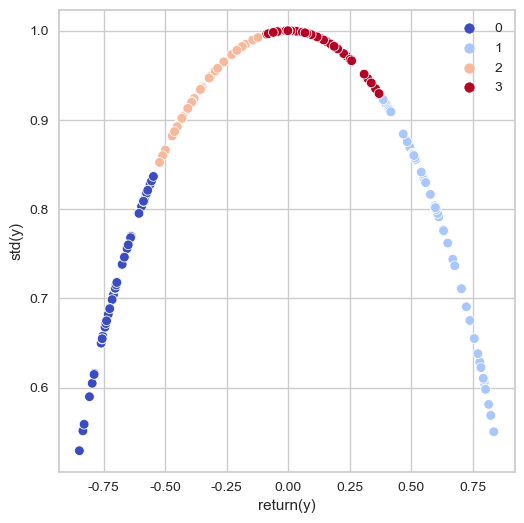

In [ ]:
plt.figure(figsize=(20, 6))

X = final_df

plt.subplot(131)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,1], data=final_df, hue=clusters.labels_, palette='coolwarm')
plt.show()

In [ ]:
kospi200["Cluster"] = final_df["Cluster"]

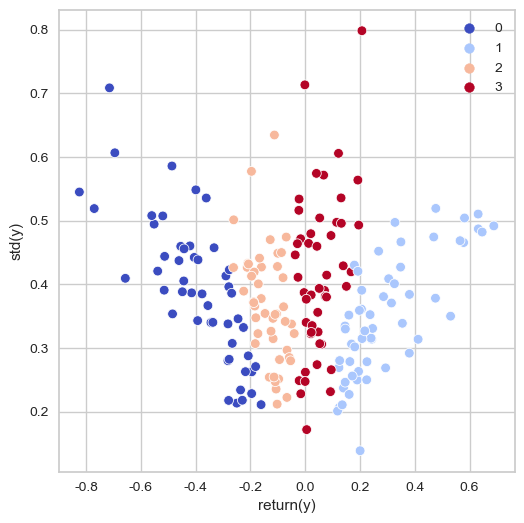

In [ ]:
plt.figure(figsize=(20, 6))

X = kospi200

plt.subplot(131)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,1], data=kospi200, hue=clusters.labels_, palette='coolwarm')
plt.show()

## 군집별 csv파일 저장

In [ ]:
# for i in range(4):
#     cluster = clustered_result.groupby('labels').get_group(i)
#     cluster.to_csv(f"cluster_{i}.csv", index=False)

## 2022년 Ticker별 csv파일 저장

In [ ]:
# kospi200.to_csv("return_std.csv",index=True)

## 2022년 Ticker별 주가 csv파일 저장

In [ ]:
# ddf = df_close.dropna(axis=1)
# ddf.to_csv("stock_prcie.csv",index=True)